In [2]:
!pip install jcopml

  Preparing metadata (setup.py) ... done
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32194 sha256=2c7bb1ad702b80c5061ce6fa77cb6a2d8260df4e1bdfba329d8937b9a1d2e8f9
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built jcopml


In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [22]:
df = pd.read_csv('/kaggle/input/taxi-fare/taxi_fare.csv', parse_dates=['pickup_datetime']) # di lakukan parse tanggal dan waktu agar lebih mudah memecah ke data tanggal dan waktu
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


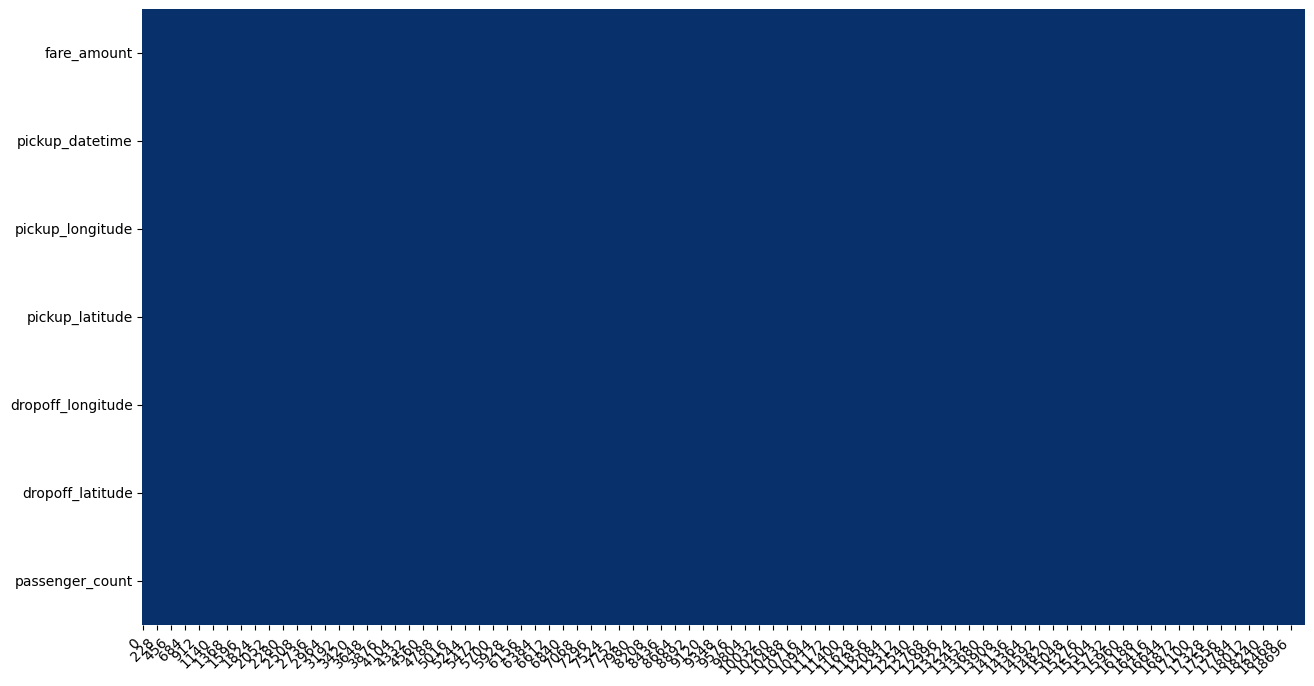

In [23]:
plot_missing_value(df)

,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


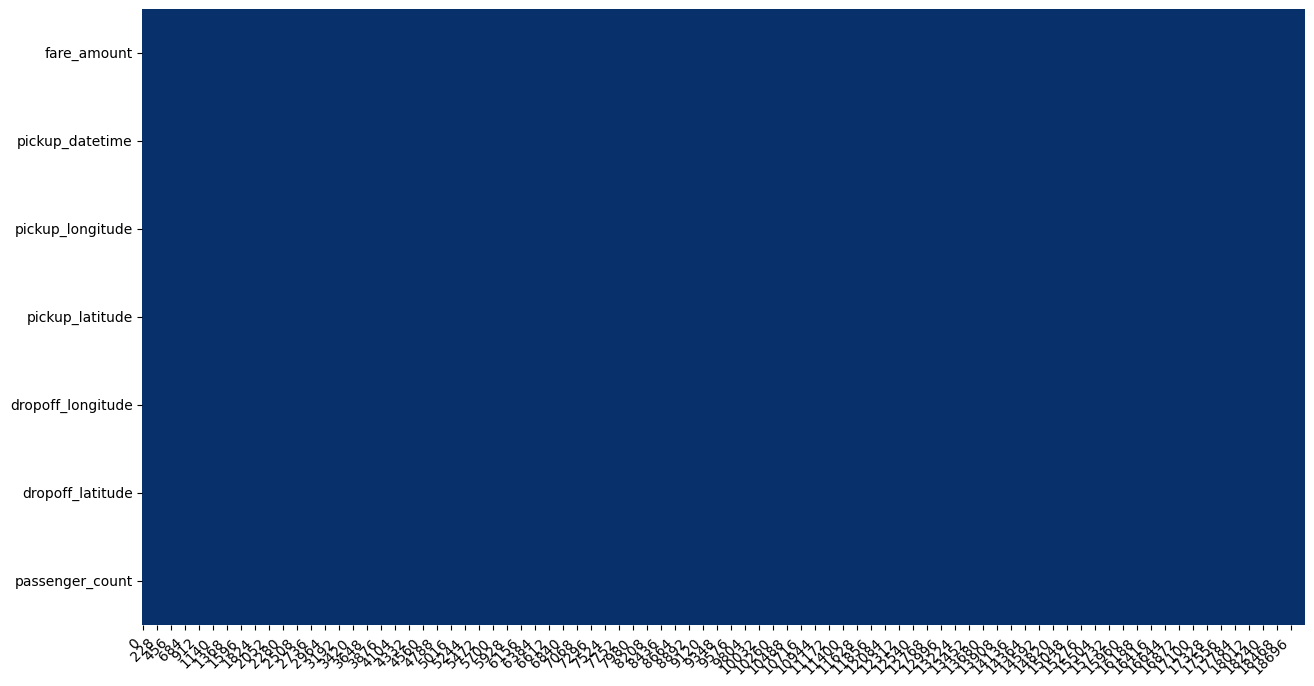

In [24]:
plot_missing_value(df, return_df=True)

In [25]:
df.dropna(inplace=True)

# Feature Engineering - Extract Time Feature

In [26]:
pickup_dt = df.pickup_datetime.dt # terdapat .dt karena sudah dilakukan parse pada saat melakukan read data
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


# Feature Engineering - Extract Distance Feature (Menggunakan rumus/metode Menhatane Distance)

In [27]:
df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Dataset Splitting

In [28]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape, X_train.shape, y_train.shape

((15134, 6), (3784, 6), (15134, 6), (15134,))

# Training

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [30]:
df.columns

Index(['fare_amount', 'passenger_count', 'year', 'month', 'day', 'hour',
       'distance'],
      dtype='object')

## Tanpa polynomial

In [33]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['passenger_count', 'distance', 'year']), # year masuk numeric karena datanya berkelanjutan (continous)
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour']) # month, day, & hour masuk kategorik karena terdapat batasan bulan, tahun, dan jam (discrete)
])

# Pipeline
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

# Parameter Tunning
model = GridSearchCV(lr_pipeline, gsp.linreg_params, cv=3, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'algo__fit_intercept': True}
0.02308676260847775 0.015618470560451144 0.019173531932462073


## Dengan Polynomial

In [34]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['passenger_count', 'distance', 'year']), 
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour']) 
])

# Pipeline
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

# Parameter Tunning
model = GridSearchCV(lr_pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': False, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.023086678453141385 0.015619724434134211 0.019163864033169387


#### Masih Jelek, mari kita cari cara yang lain!

# Feature Importance
Selama `model masih jelek`, `jangan` melakukan `Feature Importance`, karena kita `tidak bisa percaya` dengan Feature yang digunakan

# Evaluation

In [35]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

### Actual vs Prediction Plot

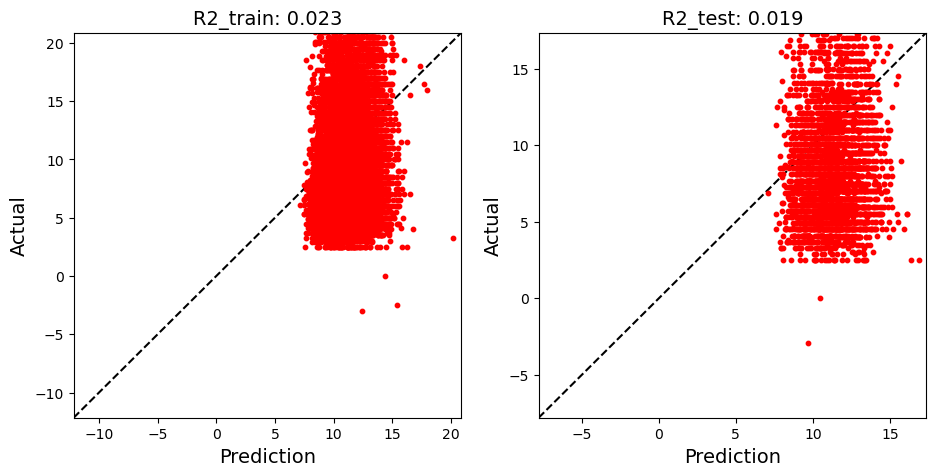

In [36]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

### Residual Plot

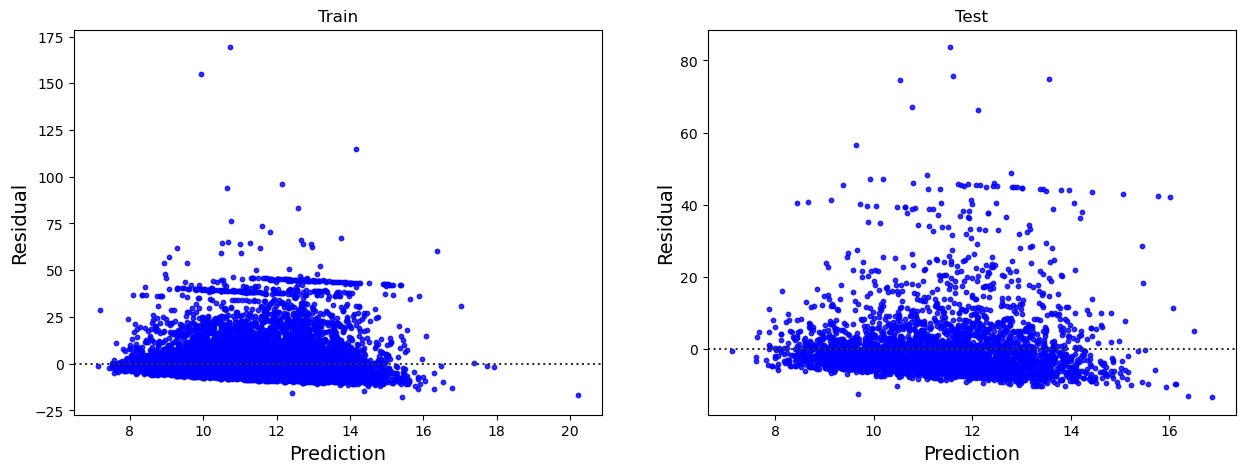

In [38]:
plot_residual(X_train, y_train, X_test, y_test, model)

#### Karena Pada Residual Plot terjadi **`IMBALANCE`** maka solusinya yaitu melakukan **`TRANSFORMATION`**
Saran Referensi Residual Plot dan Solusi:

https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/

# Mari kita coba dengan Transformation

In [39]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'distance', 'year']), 
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour'])
])

# Pipeline
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

# Parameter Tunning
model = GridSearchCV(lr_pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7171834239099559 0.7126445296418605 0.7426900604421498


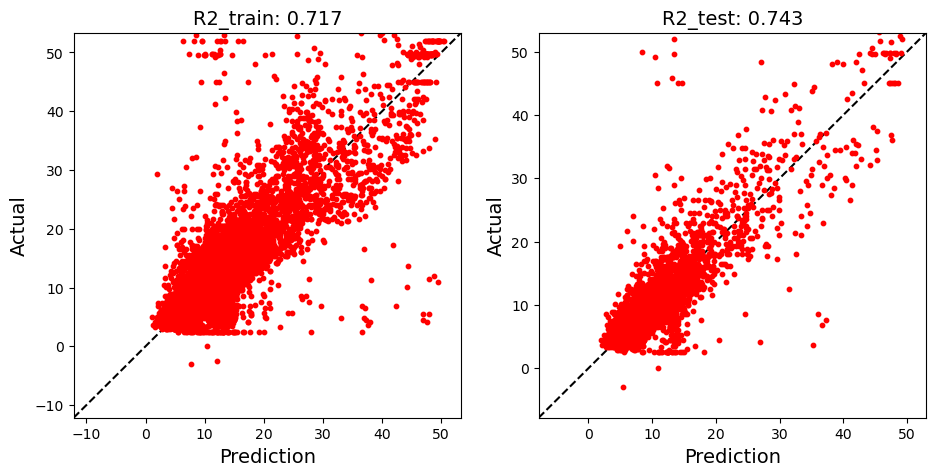

In [41]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

## Termyata Resdiual Plot tidak berbohong, Hanya dengan Linear Regression dapat menghasilkan model yang cukup bagus :D